In [2]:
import pandas as pd
import numpy as np
import os
import tensorflow


from tensorflow.python.keras.models import Input,Model,Sequential
from tensorflow.keras.layers import Input, Dense, LSTM,Embedding,Dropout,Activation,Reshape,Dense,GRU,Add,Flatten,Concatenate,Bidirectional

from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical,plot_model
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
from tensorflow.keras.layers import concatenate

In [5]:
data = pd.read_csv("/kaggle/input/lemma-data/lemmatized_dataset.csv")
data.head()

,Headline,Body ID,Stance,articleBody
0,police find mass graf with at least 15 body ne...,712,unrelated,danny boyle is directing the untitled film set...
1,hundred of palestinian flee flood in gaza a is...,158,agree,hundred of palestinian we are evacuated from t...
2,christian bale pass on role of steve job actor...,137,unrelated,30yearold moscow resi wouldent wa hospitalized...
3,hbo and apple in talk for 15month apple tv str...,1034,unrelated,reuters a canadian soldier wa shot at the cana...
4,spi woulder burrowe would through tourist stom...,1923,disagree,fear not arachnophobes the story of bunburys s...


In [6]:
data['stance_cat'] = data['Stance'].map({'agree':0,'disagree':1,'discuss':2,'unrelated':3}).astype(int)
data['Stance'].value_counts()

Stance
unrelated    36545
discuss       8909
agree         3678
disagree       840
Name: count, dtype: int64

In [12]:
corpus = np.r_[data['Headline'].values,data['articleBody'].values]
print(49972*2)
print(len(corpus)) # first 49972 contains the Headline and next 49972 contains the articleBody

vocabulary = []
for sentence in corpus:
    vocabulary.extend(sentence.split(' '))

vocabulary = list(set(vocabulary))
vocab_length = len(vocabulary)
print("Vocabulary Length is {0}".format(vocab_length))

99944
99944
Vocabulary Length is 23241


In [13]:
max_features = 5000
MAX_NB_WORDS = 24000
EMBEDDING_DIM = 50
MAX_SEQUENCE_LENGTH = 64

In [14]:
GLOVE_DIR = "/kaggle/input/glove50d/glove.6B.50d.txt"
def setup_embedding_index():
    embedding_index=dict()
    f = open(GLOVE_DIR,encoding='utf-8')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.array(values[1:],dtype='float32')
        embedding_index[word] = coefs
    f.close()
    return embedding_index
embeddings_index = setup_embedding_index()

In [16]:
print(len(embeddings_index['the']))

50


In [17]:
tokenizer_headline = Tokenizer(num_words=max_features, split=' ')
tokenizer_headline.fit_on_texts(data.loc[:,'Headline'].values)
vocab_headline_length = len(tokenizer_headline.word_index)+1

encoded_docs_headline = tokenizer_headline.texts_to_sequences(data.loc[:,'Headline'])
padded_docs_headline = pad_sequences(encoded_docs_headline, maxlen=16, padding='post')

print(vocab_headline_length)
word_index_headline = tokenizer_headline.word_index

NUM_WORDS_HEADLINE = vocab_headline_length

3204


In [18]:
tokenizer_body = Tokenizer(num_words=max_features, split=' ')
tokenizer_body.fit_on_texts(data.loc[:,'articleBody'].values)
vocab_body_length = len(tokenizer_body.word_index)+1

encoded_docs_body = tokenizer_body.texts_to_sequences(data.loc[:,'articleBody'])
padded_docs_body = pad_sequences(encoded_docs_body, maxlen=48, padding='post')

print(vocab_body_length)
word_index_body = tokenizer_body.word_index


NUM_WORDS_BODY = vocab_body_length
print(NUM_WORDS_BODY)

23084
23084


In [19]:
embedding_matrix_headline = np.zeros((NUM_WORDS_HEADLINE, EMBEDDING_DIM))

for word, i in tokenizer_headline.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_headline[i] = embedding_vector
dims = len(embedding_matrix_headline[0])

print(dims)

50


In [20]:
embedding_matrix_body = np.zeros((NUM_WORDS_BODY, EMBEDDING_DIM))

for word, i in tokenizer_body.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_body[i] = embedding_vector
dims = len(embedding_matrix_body[0])

print(dims)

50


In [21]:
print(padded_docs_headline.shape)
print(padded_docs_body.shape)

(49972, 16)
(49972, 48)


**Model Architecture**

In [22]:
input_headline = Input(shape=(16,), name='input_headline')
input_body = Input(shape=(48,), name='input_body')

# Embedding layers
embedding_headline = Embedding(input_dim=vocab_headline_length, output_dim=50, input_shape=(16,))(input_headline)
embedding_body = Embedding(input_dim=vocab_body_length, output_dim=50, input_shape=(48,))(input_body)

# Concatenate embedding layers
additional_layer = Concatenate(axis=1)([embedding_headline, embedding_body])

# LSTM layer
lstm = LSTM(64)(additional_layer)

# Dropout layer
drop = Dropout(0.25)(lstm)

# Output layer
output = Dense(4, activation='sigmoid')(drop)

# Create model
model = tensorflow.keras.Model(inputs=[input_headline, input_body], outputs=output)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
model.compile(optimizer = 'adam',loss ='categorical_crossentropy',metrics = ['accuracy'])

In [24]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_headline      │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_body          │ (None, 48)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 16, 50)    │    160,200 │ input_headline[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 48, 50)    │  1,154,200 │ input_body[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 50)    │          0 │ embedding[0][0],  │
│ (Concatenate)       │                   │            │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │     29,440 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 4)         │        260 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,344,100 (5.13 MB)

 Trainable params: 1,344,100 (5.13 MB)

 Non-trainable params: 0 (0.00 B)

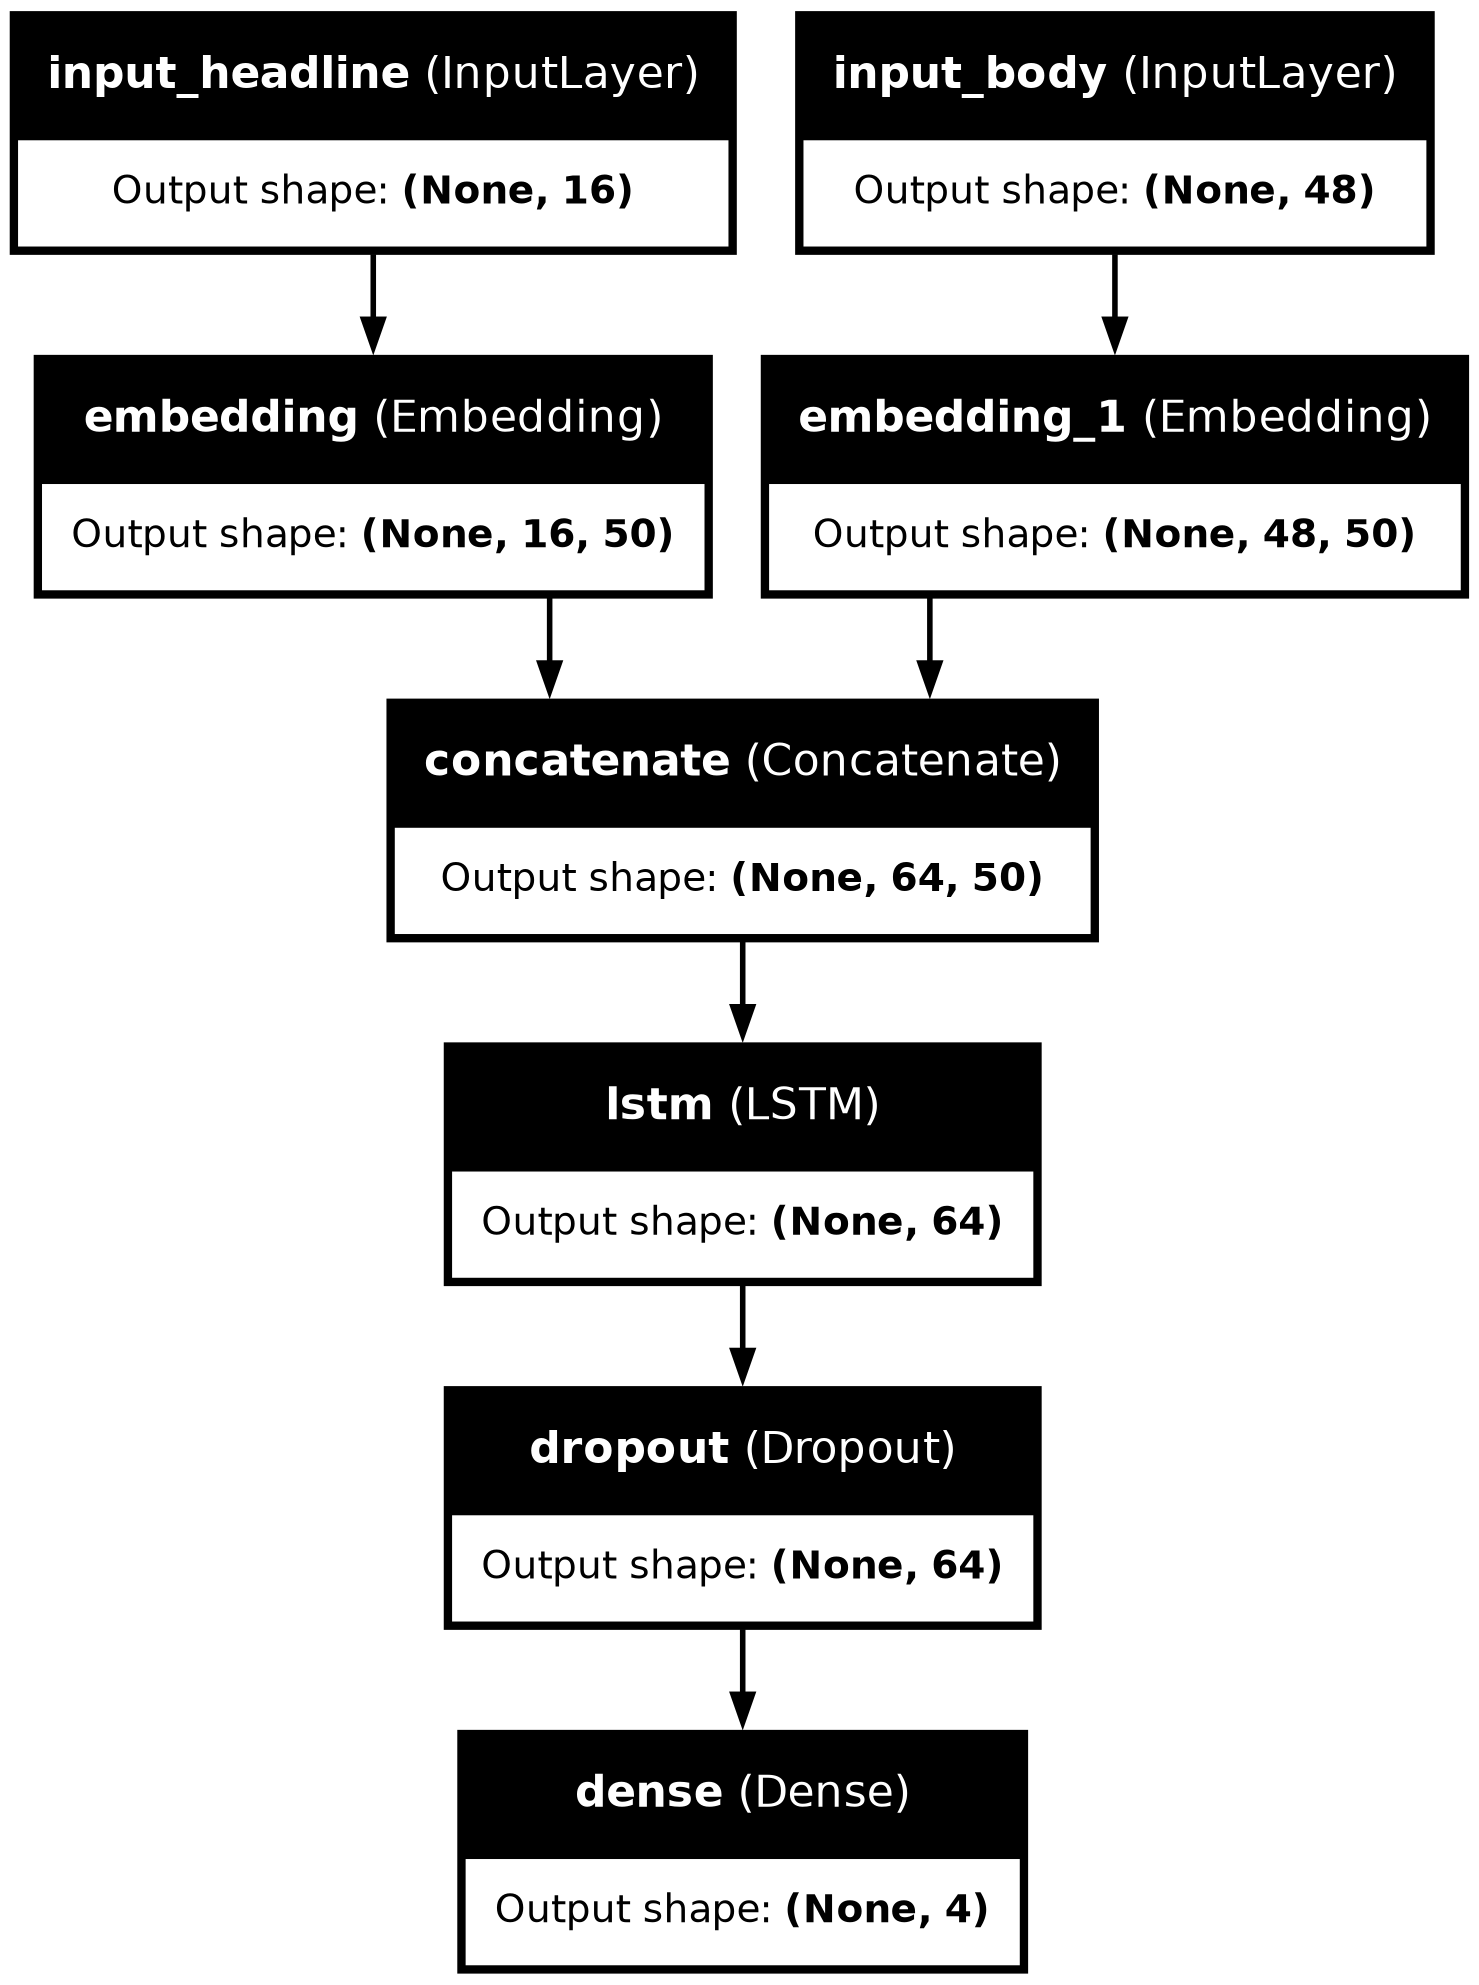

In [25]:
plot_model(model, to_file='model_glove_lstm.png', show_shapes=True, show_layer_names=True)

In [26]:
padded_docs_headline_train = padded_docs_headline[:int(len(padded_docs_headline)*0.9),:]
padded_docs_headline_test = padded_docs_headline[int(len(padded_docs_headline)*0.9):,:]

padded_docs_body_train = padded_docs_body[:int(len(padded_docs_body)*0.9),:]
padded_docs_body_test = padded_docs_body[int(len(padded_docs_body)*0.9):,:]

labels = to_categorical(data.loc[:,'stance_cat'])

labels_train = labels[:int(len(labels)*0.9),:]
labels_test = labels[int(len(labels)*0.9):,:]

In [27]:
model_history = model.fit([padded_docs_headline_train,padded_docs_body_train],labels_train,epochs=40,shuffle=True,verbose=1,
                          validation_data=([padded_docs_headline_test,padded_docs_body_test],labels_test)
                                          )

Epoch 1/40
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.7423 - loss: 0.7586 - val_accuracy: 0.7945 - val_loss: 0.5723
Epoch 2/40
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8096 - loss: 0.5291 - val_accuracy: 0.8199 - val_loss: 0.5048
Epoch 3/40
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8312 - loss: 0.4771 - val_accuracy: 0.8205 - val_loss: 0.4848
Epoch 4/40
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8413 - loss: 0.4333 - val_accuracy: 0.8347 - val_loss: 0.4585
Epoch 5/40
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8451 - loss: 0.4075 - val_accuracy: 0.8551 - val_loss: 0.3858
Epoch 6/40
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8618 - loss: 0.3513 - val_accuracy: 0.8667 - val_loss: 0.3553
Epoch 7/40
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8802 - loss: 0.2997 - val_accuracy: 0.8778 - val_loss: 0.3321
Epoch 8/40
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9001 - loss: 0.2566 -

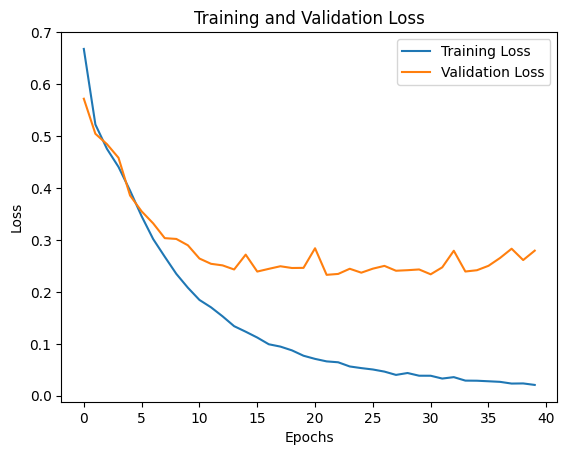

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9454 - loss: 0.3045
Test Loss: 0.2795417904853821
Test Accuracy: 0.9489796161651611


In [28]:
import matplotlib.pyplot as plt

# Train the model with training and validation sets

# Save the training history
training_loss = model_history.history['loss']
validation_loss = model_history.history['val_loss']

# Plot the loss
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on the test set
loss, accuracy = model.evaluate([padded_docs_headline_test, padded_docs_body_test], labels_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)



157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


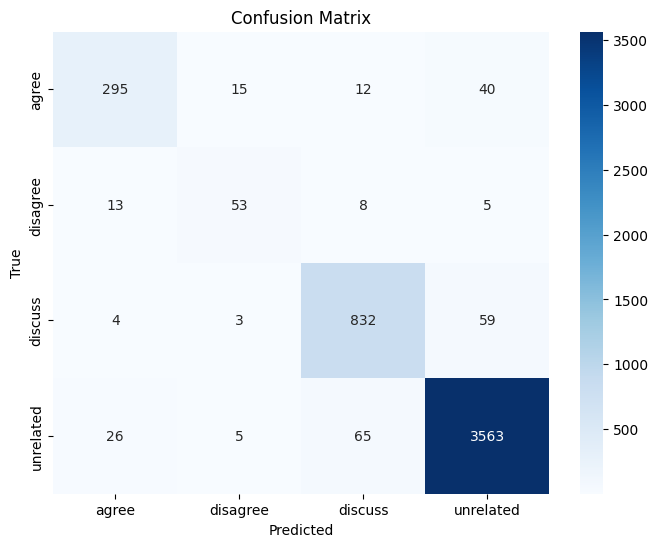

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming 'model_combined' is your trained model

# Get predictions on the test set
predictions = model.predict([padded_docs_headline_test, padded_docs_body_test])
predicted_labels = np.argmax(predictions, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(labels_test.argmax(axis=1), predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['agree', 'disagree', 'discuss', 'unrelated'],
            yticklabels=['agree', 'disagree', 'discuss', 'unrelated'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [33]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Calculate accuracy
RELATED = [0,1,2]
#'agree':0,'disagree':1,'discuss':2,'unrelated':3
accuracy = accuracy_score(labels_test.argmax(axis=1), predicted_labels)

# Calculate precision, recall, F1-score using scikit-learn
precision, recall, f1_score, _ = precision_recall_fscore_support(labels_test.argmax(axis=1), predicted_labels, average='weighted')

# Define your custom score function
def score_submission(gold_labels, test_labels):
    score = 0.0

    for i, (g, t) in enumerate(zip(gold_labels, test_labels)):
        g_stance, t_stance = g, t
        if g_stance == t_stance:
            score += 0.25
            if g_stance != 'unrelated':
                score += 0.50
        if g_stance in RELATED and t_stance in RELATED:
            score += 0.25


    return score


def report_score(actual,predicted):
    score = score_submission(actual,predicted)
    best_score = score_submission(actual,actual)

    print("Score: " +str(score) + " out of " + str(best_score) + "\t("+str(score*100/best_score) + "%)")
    return score*100/best_score


# Calculate your custom score
custom_score = score_submission(labels_test.argmax(axis=1), predicted_labels)
report_sc = report_score(labels_test.argmax(axis=1), predicted_labels)

# Print all the metrics
# print("Accuracy:", accuracy)
# print("Precision:", precision)
# print("Recall:", recall)
# print("F1 Score:", f1_score)
print("Custom Score:", custom_score)


Score: 3866.0 out of 4083.25	(94.6794832547603%)
Custom Score: 3866.0


In [31]:
from sklearn.metrics import precision_recall_fscore_support

# Calculate precision, recall, F1-score for each class using scikit-learn
precision, recall, f1_score, _ = precision_recall_fscore_support(labels_test.argmax(axis=1), predicted_labels, average=None)

# Print class-wise F1 scores
for i in range(len(precision)):
    print(f"Class {i} - Precision: {precision[i]}, Recall: {recall[i]}, F1-score: {f1_score[i]}")

# Print all the metrics
print("Accuracy:", accuracy)
print("Macro Precision:", precision.mean())
print("Macro Recall:", recall.mean())
print("Macro F1 Score:", f1_score.mean())
print("Custom Score:", custom_score)


Class 0 - Precision: 0.8727810650887574, Recall: 0.8149171270718232, F1-score: 0.8428571428571429
Class 1 - Precision: 0.6973684210526315, Recall: 0.6708860759493671, F1-score: 0.6838709677419355
Class 2 - Precision: 0.9073064340239912, Recall: 0.9265033407572383, F1-score: 0.9168044077134987
Class 3 - Precision: 0.9716389419143714, Recall: 0.9737633233123805, F1-score: 0.9726999726999728
Accuracy: 0.9489795918367347
Macro Precision: 0.8622737155199379
Macro Recall: 0.8465174667727022
Macro F1 Score: 0.8540581227531374
Custom Score: 3866.0


In [34]:
input_headline = Input(shape=(16,), name='input_headline')
input_body = Input(shape=(48,), name='input_body')

# Embedding layers
embedding_headline = Embedding(input_dim=vocab_headline_length, output_dim=50, input_shape=(16,))(input_headline)
embedding_body = Embedding(input_dim=vocab_body_length, output_dim=50, input_shape=(48,))(input_body)

# Concatenate embedding layers
additional_layer = Concatenate(axis=1)([embedding_headline, embedding_body])

# LSTM layer
lstm = Bidirectional(LSTM(64))(additional_layer)

# Dropout layer
drop = Dropout(0.25)(lstm)

# Output layer
output = Dense(4, activation='sigmoid')(drop)

# Create model
model_bidirectional = tensorflow.keras.Model(inputs=[input_headline, input_body], outputs=output)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [35]:
model_bidirectional.compile(optimizer = 'adam',loss ='categorical_crossentropy',metrics = ['accuracy'])
model_bidirectional.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_headline      │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_body          │ (None, 48)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 16, 50)    │    160,200 │ input_headline[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 48, 50)    │  1,154,200 │ input_body[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 64, 50)    │          0 │ embedding_4[0][0… │
│ (Concatenate)       │                   │            │ embedding_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 128)       │     58,880 │ concatenate_2[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 4)         │        516 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,373,796 (5.24 MB)

 Trainable params: 1,373,796 (5.24 MB)

 Non-trainable params: 0 (0.00 B)

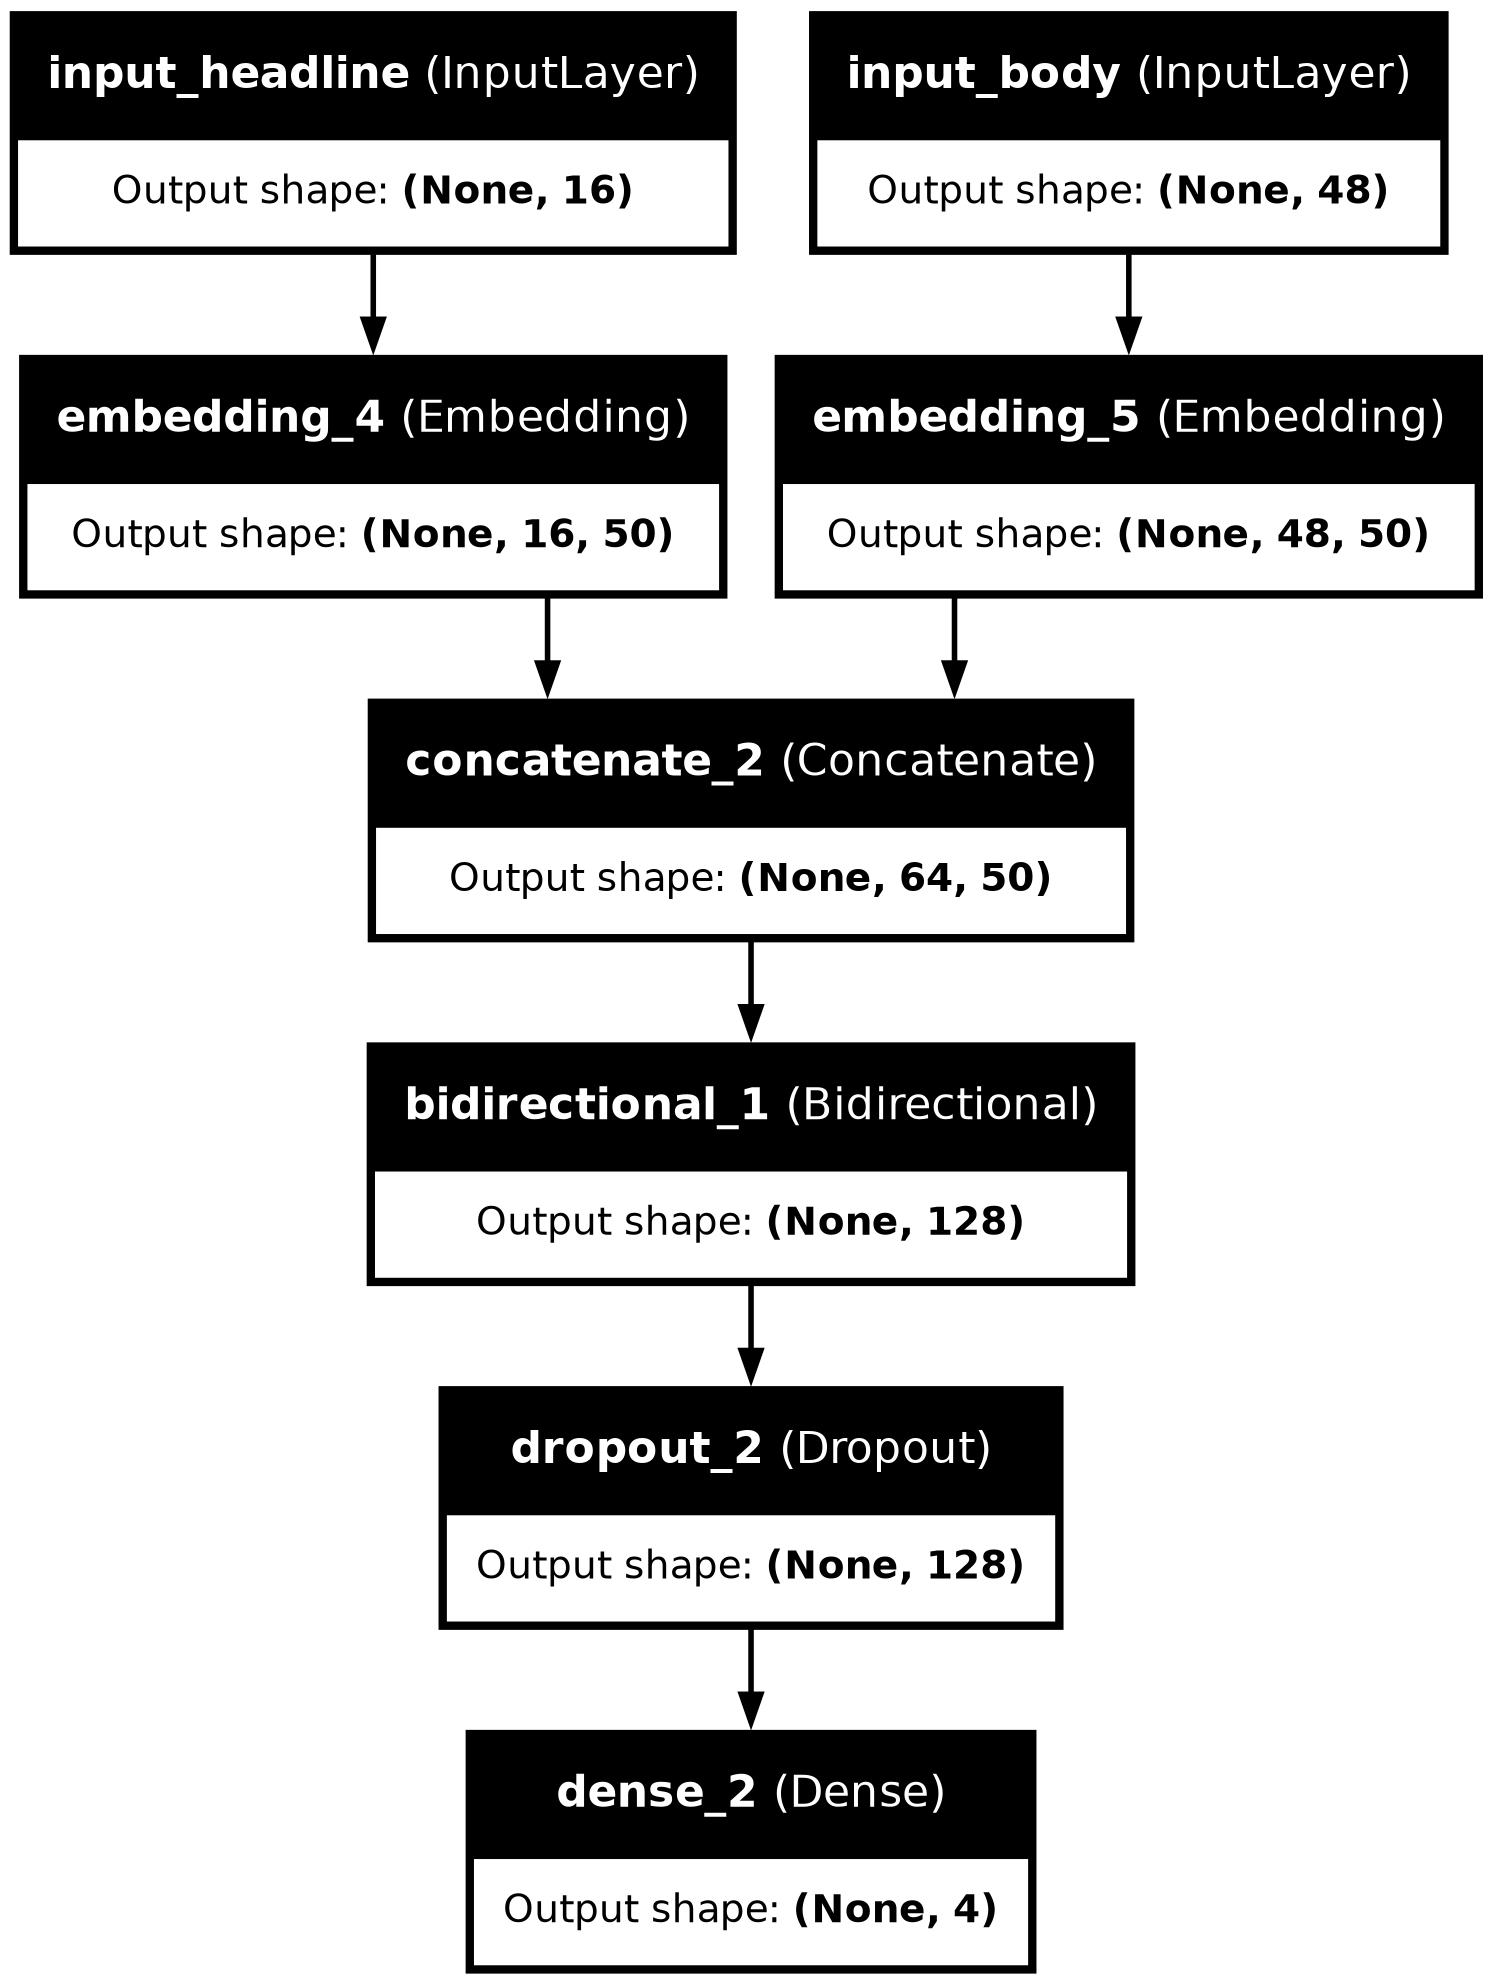

In [36]:
plot_model(model_bidirectional, to_file='model_glove_bi_lstm.png', show_shapes=True, show_layer_names=True)

In [37]:
model_bidirectional_history = model_bidirectional.fit([padded_docs_headline_train,padded_docs_body_train],labels_train,epochs=40,shuffle=True,verbose=1,
                          validation_data=([padded_docs_headline_test,padded_docs_body_test],labels_test)
                                          )

Epoch 1/40
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.7500 - loss: 0.7269 - val_accuracy: 0.8169 - val_loss: 0.4854
Epoch 2/40
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.8265 - loss: 0.4553 - val_accuracy: 0.8491 - val_loss: 0.4120
Epoch 3/40
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.8592 - loss: 0.3595 - val_accuracy: 0.8571 - val_loss: 0.3765
Epoch 4/40
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.8865 - loss: 0.2923 - val_accuracy: 0.8701 - val_loss: 0.3405
Epoch 5/40
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.9018 - loss: 0.2458 - val_accuracy: 0.8848 - val_loss: 0.3064
Epoch 6/40
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.9191 - loss: 0.2066 - val_accuracy: 0.8978 - val_loss: 0.2816
Epoch 7/40
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.9317 - loss: 0.1737 - val_accuracy: 0.9128 - val_loss: 0.2629
Epoch 8/40
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.9442 - lo

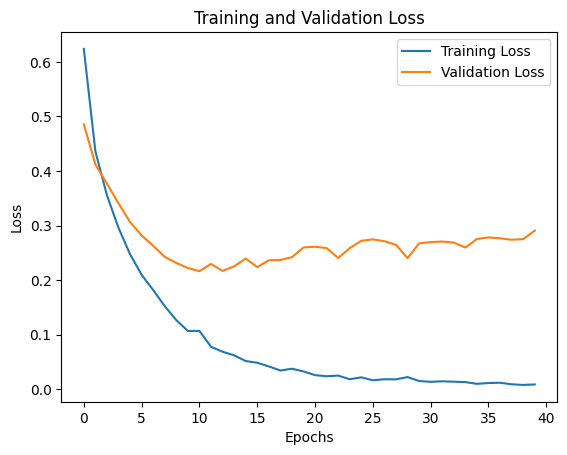

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9555 - loss: 0.3210
Test Loss: 0.2905842065811157
Test Accuracy: 0.9545818567276001


In [38]:
# Save the training history
training_loss_bidirectional = model_bidirectional_history.history['loss']
validation_loss_bidirectional = model_bidirectional_history.history['val_loss']

# Plot the loss
plt.plot(training_loss_bidirectional, label='Training Loss')
plt.plot(validation_loss_bidirectional, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on the test set
loss_bidirectional, accuracy_bidirectional = model_bidirectional.evaluate([padded_docs_headline_test, padded_docs_body_test], labels_test)
print('Test Loss:', loss_bidirectional)
print('Test Accuracy:', accuracy_bidirectional)


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


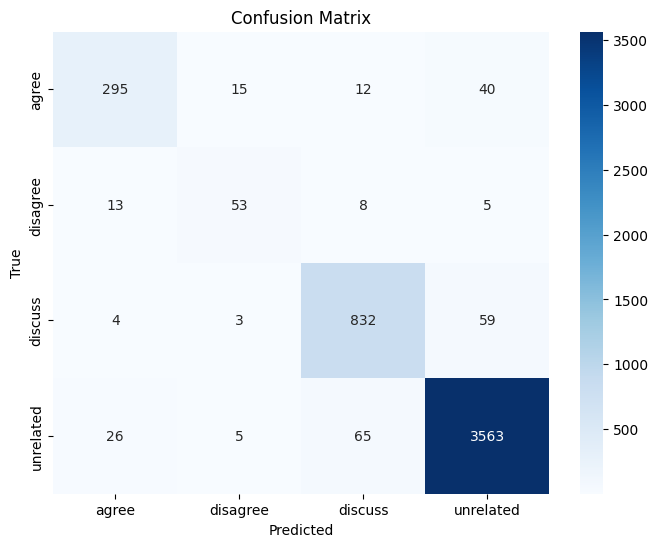

In [39]:
predictions_bidirectional = model_bidirectional.predict([padded_docs_headline_test, padded_docs_body_test])
predicted_labels_bidirectional = np.argmax(predictions_bidirectional, axis=1)

# Compute the confusion matrix
conf_matrix_bidirectional = confusion_matrix(labels_test.argmax(axis=1), predicted_labels_bidirectional)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['agree', 'disagree', 'discuss', 'unrelated'],
            yticklabels=['agree', 'disagree', 'discuss', 'unrelated'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [40]:
# Calculate accuracy
RELATED = [0,1,2]
#'agree':0,'disagree':1,'discuss':2,'unrelated':3
accuracy_bidirectional = accuracy_score(labels_test.argmax(axis=1), predicted_labels_bidirectional)

# Calculate precision, recall, F1-score using scikit-learn
precision_bidirectional, recall_bidirectional, f1_score_bidirectional, _ = precision_recall_fscore_support(labels_test.argmax(axis=1), predicted_labels_bidirectional, average='weighted')

# Calculate your custom score
custom_score_bidirectional = score_submission(labels_test.argmax(axis=1), predicted_labels_bidirectional)
report_sc_bidirectional = report_score(labels_test.argmax(axis=1), predicted_labels_bidirectional)

# Print all the metrics
# print("Accuracy:", accuracy)
# print("Precision:", precision)
# print("Recall:", recall)
# print("F1 Score:", f1_score)
print("Custom Score:", custom_score_bidirectional)

Score: 3887.5 out of 4083.25	(95.2060246127472%)
Custom Score: 3887.5


In [42]:
# Calculate precision, recall, F1-score for each class using scikit-learn
#'agree':0,'disagree':1,'discuss':2,'unrelated':3
precision_bidirectional, recall_bidirectional, f1_score_bidirectional, _ = precision_recall_fscore_support(labels_test.argmax(axis=1), predicted_labels_bidirectional, average=None)

# Print class-wise F1 scores
for i in range(len(precision_bidirectional)):
    print(f"Class {i} - Precision: {precision_bidirectional[i]}, Recall: {recall_bidirectional[i]}, F1-score: {f1_score_bidirectional[i]}")

# Print all the metrics
print("Accuracy:", accuracy_bidirectional)
print("Macro Precision:", precision_bidirectional.mean())
print("Macro Recall:", recall_bidirectional.mean())
print("Macro F1 Score:", f1_score_bidirectional.mean())
print("Custom Score:", custom_score_bidirectional)

Class 0 - Precision: 0.8712328767123287, Recall: 0.8784530386740331, F1-score: 0.874828060522696
Class 1 - Precision: 0.7910447761194029, Recall: 0.6708860759493671, F1-score: 0.726027397260274
Class 2 - Precision: 0.9283314669652856, Recall: 0.923162583518931, F1-score: 0.9257398101619206
Class 3 - Precision: 0.9722297849169617, Recall: 0.9759497130363487, F1-score: 0.9740861974904529
Accuracy: 0.9545818327330933
Macro Precision: 0.8907097261784948
Macro Recall: 0.86211285279467
Macro F1 Score: 0.8751703663588359
Custom Score: 3887.5


## IMPROVING THE MODEL WITH DROPOUT AND BATCH NORMALIZATION

In [58]:
from tensorflow.keras.layers import Input, Embedding, Concatenate, Bidirectional, LSTM, Dropout, Dense, BatchNormalization
input_headline = Input(shape=(16,), name='input_headline')
input_body = Input(shape=(48,), name='input_body')

# Embedding layers
embedding_headline = Embedding(input_dim=vocab_headline_length, output_dim=50, input_shape=(16,))(input_headline)
embedding_body = Embedding(input_dim=vocab_body_length, output_dim=50, input_shape=(48,))(input_body)

# Concatenate embedding layers
additional_layer = Concatenate(axis=1)([embedding_headline, embedding_body])

lstm = Bidirectional(LSTM(64))(additional_layer)

# Batch normalization
batch_norm = BatchNormalization()(lstm)

# Dropout layer
drop = Dropout(0.5)(batch_norm)

# Output layer
output = Dense(4, activation='sigmoid')(drop)

# Create model
model_bidirectional_batchnorm = tensorflow.keras.Model(inputs=[input_headline, input_body], outputs=output)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [59]:
model_bidirectional_batchnorm.compile(optimizer = 'adam',loss ='categorical_crossentropy',metrics = ['accuracy'])
model_bidirectional_batchnorm.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_headline      │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_body          │ (None, 48)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_12        │ (None, 16, 50)    │    160,200 │ input_headline[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_13        │ (None, 48, 50)    │  1,154,200 │ input_body[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 64, 50)    │          0 │ embedding_12[0][… │
│ (Concatenate)       │                   │            │ embedding_13[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 128)       │     58,880 │ concatenate_6[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ bidirectional_5[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 4)         │        516 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,374,308 (5.24 MB)

 Trainable params: 1,374,052 (5.24 MB)

 Non-trainable params: 256 (1.00 KB)

In [61]:
padded_docs_headline_train = padded_docs_headline[:int(len(padded_docs_headline)*0.9),:]
padded_docs_headline_test = padded_docs_headline[int(len(padded_docs_headline)*0.9):,:]

padded_docs_body_train = padded_docs_body[:int(len(padded_docs_body)*0.9),:]
padded_docs_body_test = padded_docs_body[int(len(padded_docs_body)*0.9):,:]

labels = to_categorical(data.loc[:,'stance_cat'])

labels_train = labels[:int(len(labels)*0.9),:]
labels_test = labels[int(len(labels)*0.9):,:]

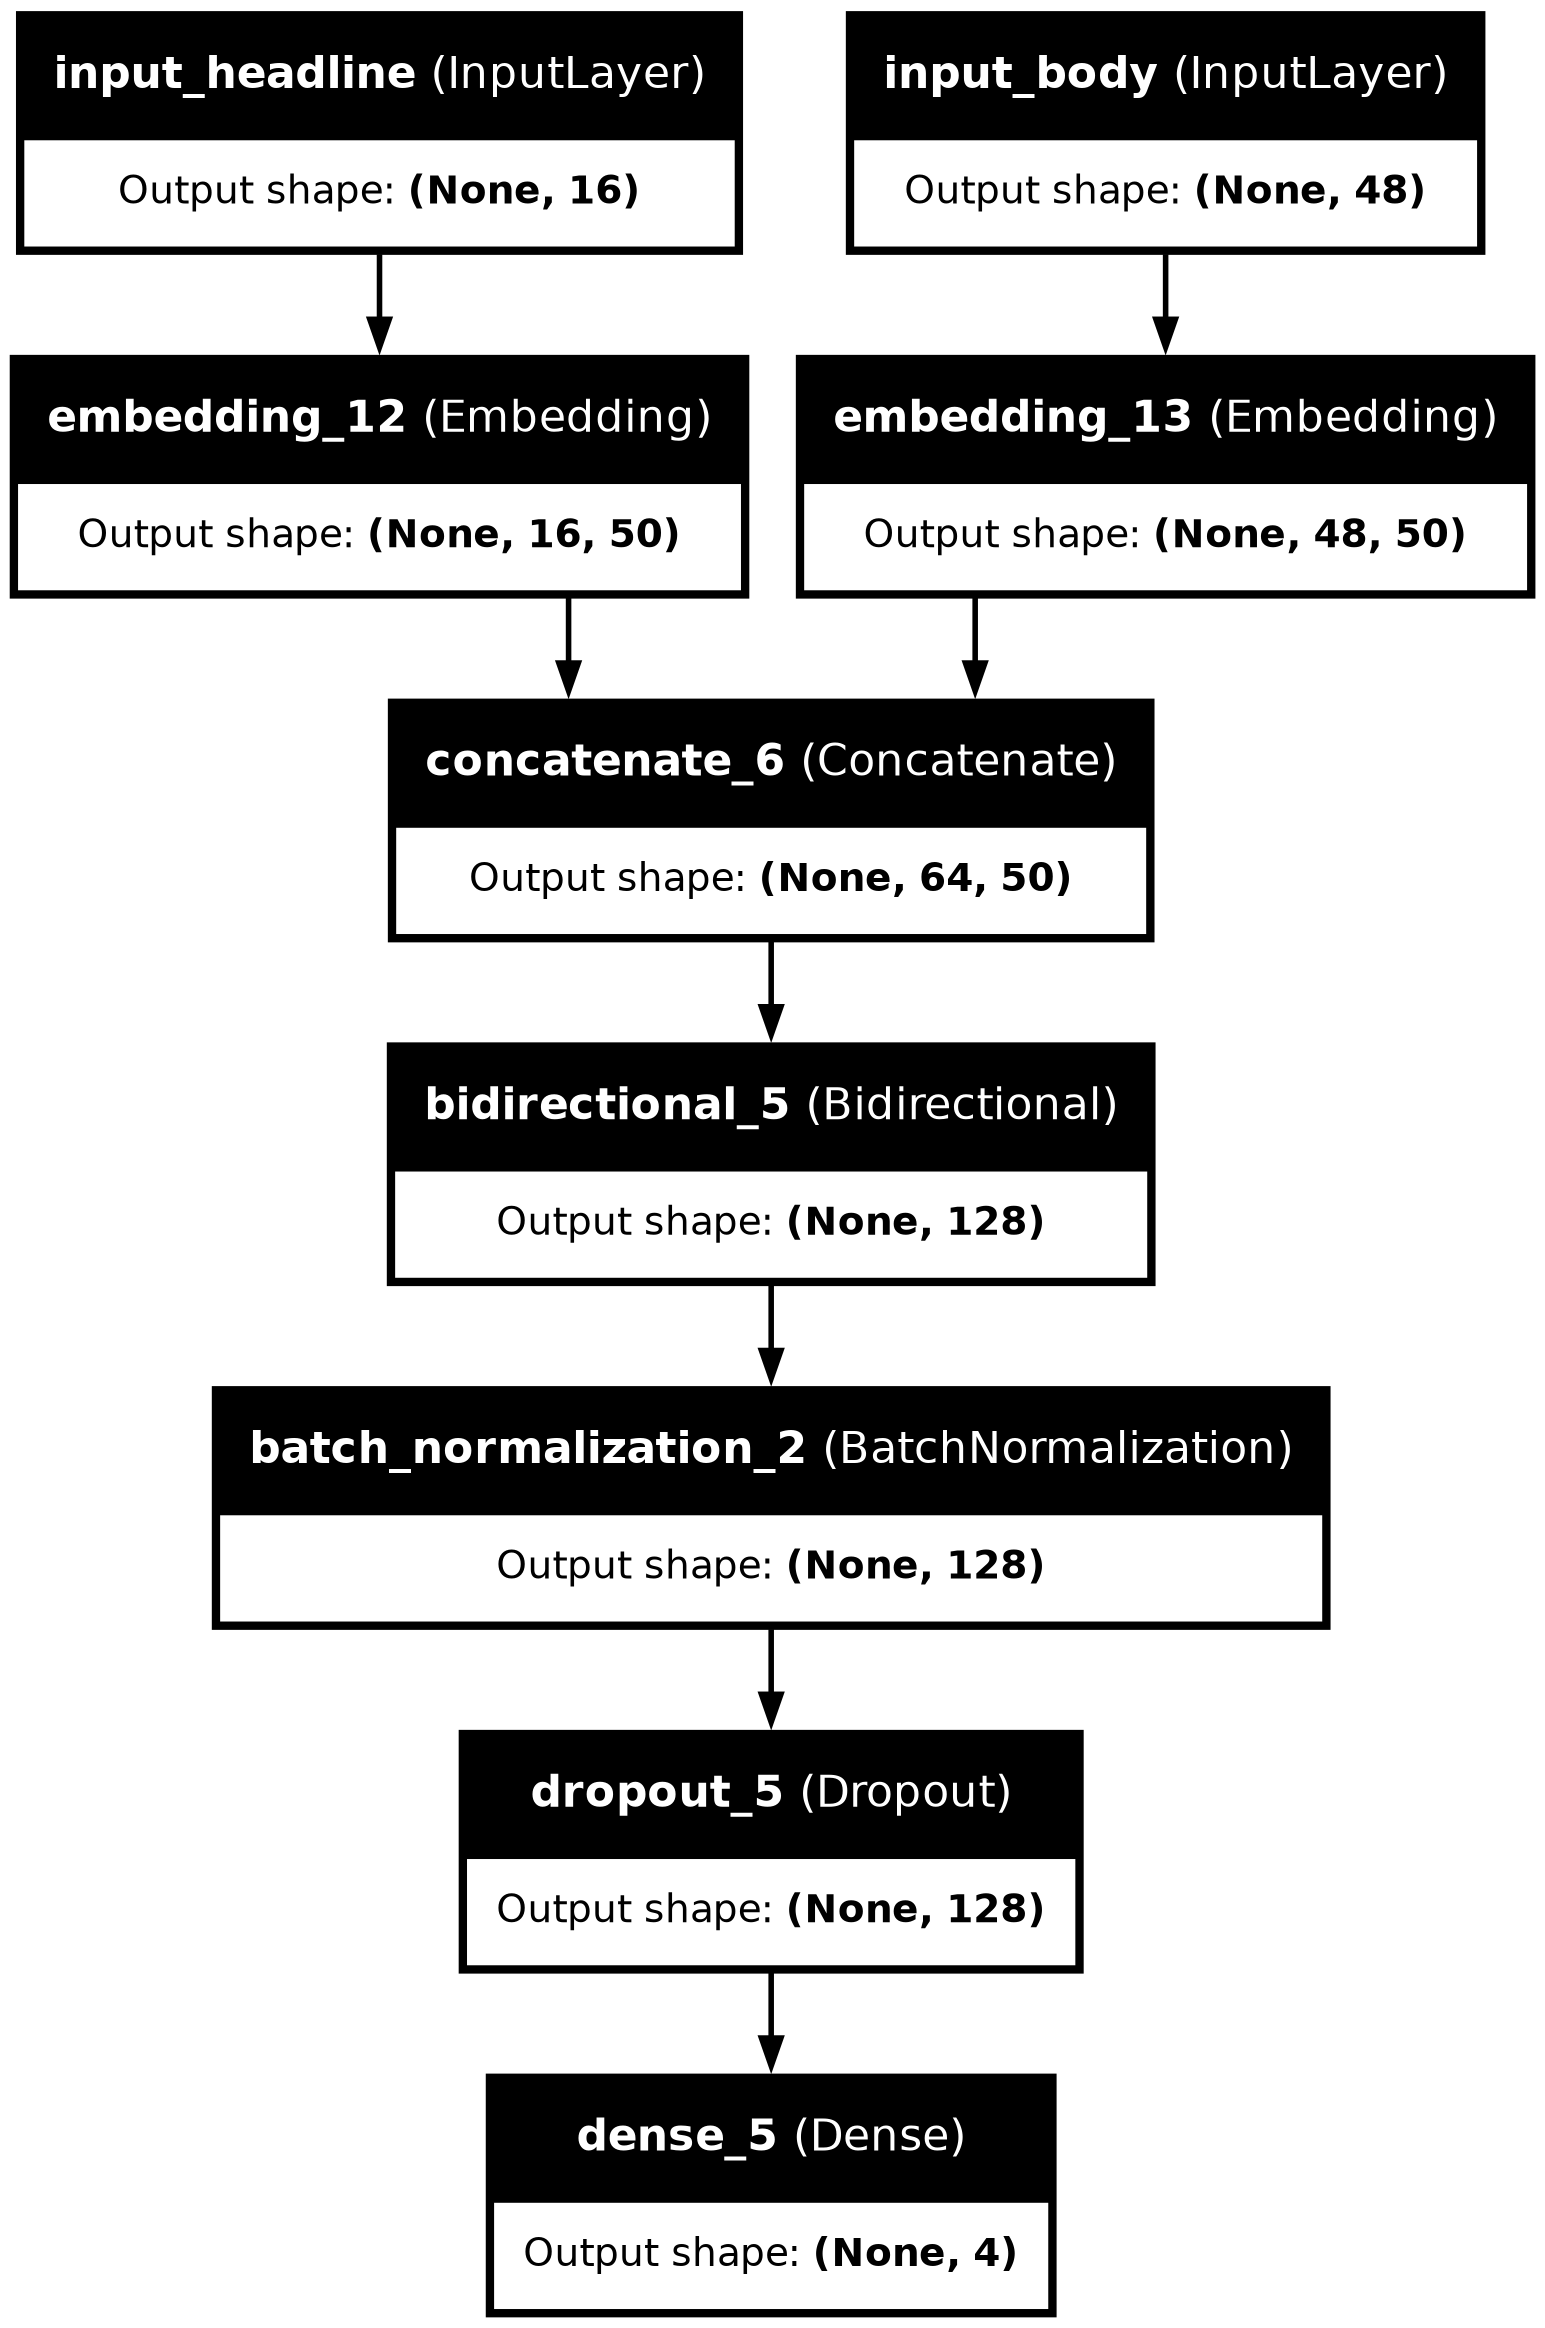

In [62]:
plot_model(model_bidirectional_batchnorm, to_file='model_glove_bi_normal.png', show_shapes=True, show_layer_names=True)

In [63]:
model_bibatch_history = model_bidirectional_batchnorm.fit([padded_docs_headline_train,padded_docs_body_train],labels_train,epochs=40,shuffle=True,verbose=1,
                          validation_data=([padded_docs_headline_test,padded_docs_body_test],labels_test)
                                          )

Epoch 1/40
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.7099 - loss: 0.7793 - val_accuracy: 0.6995 - val_loss: 0.6981
Epoch 2/40
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.8126 - loss: 0.5000 - val_accuracy: 0.7413 - val_loss: 0.6344
Epoch 3/40
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.8227 - loss: 0.4592 - val_accuracy: 0.8145 - val_loss: 0.4840
Epoch 4/40
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.8364 - loss: 0.4343 - val_accuracy: 0.8283 - val_loss: 0.4657
Epoch 5/40
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.8376 - loss: 0.4185 - val_accuracy: 0.8169 - val_loss: 0.4824
Epoch 6/40
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.8487 - loss: 0.3977 - val_accuracy: 0.8371 - val_loss: 0.4200
Epoch 7/40
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.8657 - loss: 0.3544 - val_accuracy: 0.8653 - val_loss: 0.3554
Epoch 8/40
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.8780 -

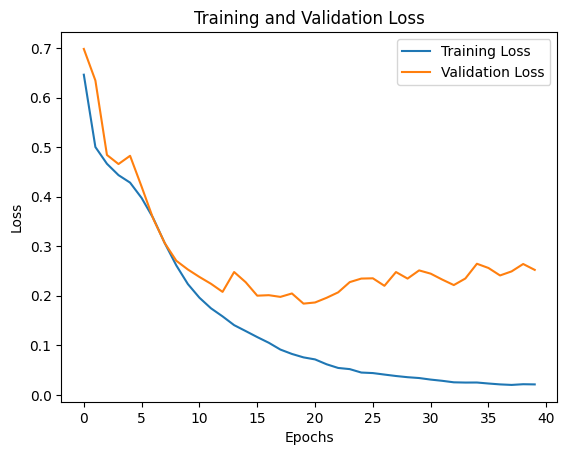

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9585 - loss: 0.2520
Test Loss: 0.2520895302295685
Test Accuracy: 0.9577831029891968


In [67]:
# Save the training history
training_loss_binorm = model_bibatch_history.history['loss']
validation_loss_binorm = model_bibatch_history.history['val_loss']

# Plot the loss
plt.plot(training_loss_binorm, label='Training Loss')
plt.plot(validation_loss_binorm, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on the test set
loss_binorm, accuracy_binorm = model_bidirectional_batchnorm.evaluate([padded_docs_headline_test, padded_docs_body_test], labels_test)
print('Test Loss:', loss_binorm)
print('Test Accuracy:', accuracy_binorm)


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


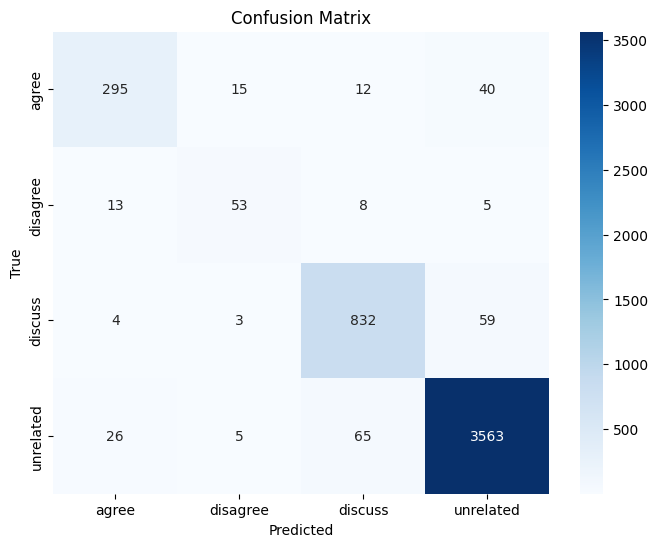

In [68]:
predictions_binorm = model_bidirectional_batchnorm.predict([padded_docs_headline_test, padded_docs_body_test])
predicted_labels_binorm = np.argmax(predictions_binorm, axis=1)

# Compute the confusion matrix
conf_matrix_binorm = confusion_matrix(labels_test.argmax(axis=1), predicted_labels_bidirectional)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['agree', 'disagree', 'discuss', 'unrelated'],
            yticklabels=['agree', 'disagree', 'discuss', 'unrelated'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [72]:
# Calculate accuracy
RELATED = [0,1,2]
#'agree':0,'disagree':1,'discuss':2,'unrelated':3
accuracy_binorm= accuracy_score(labels_test.argmax(axis=1), predicted_labels_binorm)

# Calculate precision, recall, F1-score using scikit-learn
precision_binorm, recall_binorm, f1_score_binorm, _ = precision_recall_fscore_support(labels_test.argmax(axis=1), predicted_labels_binorm, average='weighted')

# Calculate your custom score
custom_score_binorm = score_submission(labels_test.argmax(axis=1), predicted_labels_binorm)
report_sc_binorm = report_score(labels_test.argmax(axis=1), predicted_labels_binorm)

# Print all the metrics
# print("Accuracy:", accuracy)
# print("Precision:", precision)
# print("Recall:", recall)
# print("F1 Score:", f1_score)
print("Custom Score:", custom_score_binorm)

Score: 3909.0 out of 4083.25	(95.7325659707341%)
Custom Score: 3909.0


In [74]:
# Calculate precision, recall, F1-score for each class using scikit-learn
#'agree':0,'disagree':1,'discuss':2,'unrelated':3
precision_binorm, recall_binorm, f1_score_binorm, _ = precision_recall_fscore_support(labels_test.argmax(axis=1), predicted_labels_binorm, average=None)

# Print class-wise F1 scores
for i in range(len(precision_binorm)):
    print(f"Class {i} - Precision: {precision_binorm[i]}, Recall: {recall_binorm[i]}, F1-score: {f1_score_binorm[i]}")

# Print all the metrics
print("Accuracy:", accuracy_binorm)
print("Macro Precision:", precision_binorm.mean())
print("Macro Recall:", recall_binorm.mean())
print("Macro F1 Score:", f1_score_binorm.mean())
print("Custom Score:", custom_score_binorm)

Class 0 - Precision: 0.8643617021276596, Recall: 0.8977900552486188, F1-score: 0.8807588075880759
Class 1 - Precision: 0.8169014084507042, Recall: 0.7341772151898734, F1-score: 0.7733333333333333
Class 2 - Precision: 0.9113247863247863, Recall: 0.9498886414253898, F1-score: 0.9302071973827699
Class 3 - Precision: 0.982295988934993, Recall: 0.970483738726428, F1-score: 0.9763541380258455
Accuracy: 0.9577831132452981
Macro Precision: 0.8937209714595358
Macro Recall: 0.8880849126475776
Macro F1 Score: 0.8901633690825062
Custom Score: 3909.0
